# ***AI for Climate change: Unveiling Pathways to Sustainable Development through Greenhouse Gas Emission Predictions***

In [2]:
# Load your dataset
from google.colab import files
uploaded = files.upload()

Saving data_climate_change.xlsx to data_climate_change.xlsx


# Import package

In [3]:
# Install necessary package
!pip install lime
!pip install catboost
!pip install xgboost
!pip install dtreeviz
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=5f5d6dc409bb10b0611a54034d51829c7f35ca5f639e469347278a915d7f5196
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 6.6 MB/s eta 0:00:00


In [4]:
# import package
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split, RepeatedKFold, GroupShuffleSplit, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE # Feature selection
# Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree as sklearn_tree  # Import tree module from sklearn
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text, export_graphviz
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import dtreeviz
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import catboost
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
from xgboost import plot_tree, XGBRegressor, plot_importance
from xgboost import XGBRegressor, plot_tree as xgb_plot_tree
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lime
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
import pydotplus
from IPython.display import Image
import graphviz
from PIL import Image
import io
from sklearn.decomposition import PCA
import joblib

# Import data

In [5]:
# Load the Excel file
file_path = 'data_climate_change.xlsx'

# Read the sheets into separate DataFrames
data_df = pd.read_excel(file_path, sheet_name='data')
train_df = pd.read_excel(file_path, sheet_name='train')
test_df = pd.read_excel(file_path, sheet_name='test')

In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3495 entries, 0 to 3494
Data columns (total 55 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   iso_code                                   3495 non-null   object 
 1   country                                    3495 non-null   object 
 2   year                                       3495 non-null   int64  
 3   consumption_co2_per_capita                 3495 non-null   float64
 4   gdp                                        3238 non-null   float64
 5   cement_co2_per_capita                      3472 non-null   float64
 6   co2_growth_prct                            3493 non-null   float64
 7   co2_including_luc_per_capita               3495 non-null   float64
 8   co2_per_capita                             3495 non-null   float64
 9   coal_co2_per_capita                        3494 non-null   float64
 10  cumulative_cement_co2   

In [7]:
data_df.head(2)

iso_code  country  year  consumption_co2_per_capita           gdp  \
0      ALB  Albania  1990                       1.686  1.294785e+10   
1      ALB  Albania  1991                       1.397  9.375844e+09   

   cement_co2_per_capita  co2_growth_prct  co2_including_luc_per_capita  \
0                  0.116          -38.566                         2.209   
1                  0.093          -22.287                         1.643   

   co2_per_capita  coal_co2_per_capita  ...  share_global_luc_co2  \
0           1.675                0.758  ...                 0.036   
1           1.299                0.448  ...                 0.024   

   share_global_oil_co2  share_global_other_co2  \
0                 0.023                     NaN   
1                 0.023                     NaN   

   share_of_temperature_change_from_ghg  temperature_change_from_ch4  \
0                                 0.035                          0.0   
1                                 0.035                          0.0   

   temperature_change_from_co2  temperature_change_from_ghg  \
0                          0.0                          0.0   
1                          0.0                          0.0   

   temperature_change_from_n2o  total_ghg  trade_co2  
0                          0.0      11.37      0.034  
1                          0.0       9.01      0.322  

[2 rows x 55 columns]

## Descriptive Statistic

In [8]:
# Define function to compute descriptive stattistics
def descriptive_statistics(df):
    stats = df.describe().T
    stats['mean'] = df.mean()
    stats['std'] = df.std()
    stats['Q1'] = df.quantile(0.25)
    stats['median'] = df.median()
    stats['Q3'] = df.quantile(0.75)
    stats = stats[['mean', 'min', '25%', 'median', '75%', 'max', 'std']]
    stats.rename(columns={'25%': 'Q1', '75%': 'Q3'}, inplace=True)
    return stats

def export_to_excel(table, filename):
    table.to_excel(filename, index=True)

In [9]:
des_stat = descriptive_statistics(data_df.iloc[:, 3:])
des_stat

mean           min  \
consumption_co2_per_capita                 6.262621e+00  0.000000e+00   
gdp                                        6.270765e+11  3.274114e+09   
cement_co2_per_capita                      1.545372e-01  0.000000e+00   
co2_growth_prct                            2.861415e+00 -9.398400e+01   
co2_including_luc_per_capita               6.956659e+00 -2.136000e+00   
co2_per_capita                             5.907160e+00  0.000000e+00   
coal_co2_per_capita                        1.312188e+00  0.000000e+00   
cumulative_cement_co2                      2.070624e+02  0.000000e+00   
cumulative_co2                             1.013470e+04  0.000000e+00   
cumulative_co2_including_luc               1.671401e+04  2.308000e+00   
cumulative_coal_co2                        5.146627e+03  0.000000e+00   
cumulative_flaring_co2                     9.597814e+01  0.000000e+00   
cumulative_gas_co2                         1.296099e+03  0.000000e+00   
cumulative_luc_co2                         7.398171e+03 -4.685670e+03   
cumulative_oil_co2                         3.346516e+03  9.530000e-01   
cumulative_other_co2                       1.281651e+02  4.900000e-02   
energy_per_capita                          2.978138e+04  1.917730e+02   
flaring_co2_per_capita                     9.989840e-02  0.000000e+00   
gas_co2_per_capita                         1.832554e+00  0.000000e+00   
ghg_excluding_lucf_per_capita              7.964868e+00  3.160000e-01   
ghg_per_capita                             8.682553e+00 -9.335000e+00   
land_use_change_co2_per_capita             1.049500e+00 -7.312000e+00   
methane_per_capita                         1.852835e+00  1.360000e-01   
nitrous_oxide_per_capita                   6.789467e-01  6.900000e-02   
oil_co2_per_capita                         2.475667e+00  2.500000e-02   
other_co2_per_capita                       9.615500e-02  8.000000e-03   
primary_energy_consumption                 1.064843e+03  2.039000e+00   
share_global_cement_co2                    8.421310e-01  0.000000e+00   
share_global_co2                           8.163897e-01  0.000000e+00   
share_global_co2_including_luc             8.376724e-01 -1.150000e-01   
share_global_coal_co2                      8.582138e-01  0.000000e+00   
share_global_cumulative_cement_co2         8.372457e-01  0.000000e+00   
share_global_cumulative_co2                8.371628e-01  0.000000e+00   
share_global_cumulative_co2_including_luc  8.936601e-01  0.000000e+00   
share_global_cumulative_coal_co2           8.683575e-01  0.000000e+00   
share_global_cumulative_flaring_co2        7.620704e-01  0.000000e+00   
share_global_cumulative_gas_co2            8.493912e-01  0.000000e+00   
share_global_cumulative_luc_co2            1.111366e+00 -6.870000e-01   
share_global_cumulative_oil_co2            7.916408e-01  0.000000e+00   
share_global_cumulative_other_co2          2.400508e+00  3.000000e-03   
share_global_flaring_co2                   7.564745e-01  0.000000e+00   
share_global_gas_co2                       8.339611e-01  0.000000e+00   
share_global_luc_co2                       9.487296e-01 -1.942000e+00   
share_global_oil_co2                       7.618045e-01  4.000000e-03   
share_global_other_co2                     2.370007e+00  4.000000e-03   
share_of_temperature_change_from_ghg       8.177737e-01 -1.000000e-03   
temperature_change_from_ch4                2.699571e-03 -1.000000e-03   
temperature_change_from_co2                6.925894e-03  0.000000e+00   
temperature_change_from_ghg                1.021173e-02  0.000000e+00   
temperature_change_from_n2o                4.420601e-04  0.000000e+00   
total_ghg                                  3.246328e+02 -1.866600e+02   
trade_co2                                 -6.246793e-01 -1.526506e+03   

                                                     Q1        median  \
consumption_co2_per_capita                 9.940000e-01  3.741000e+00   
gdp                                

In [10]:
# Export table of descriptive statistic to excel file
export_to_excel(des_stat, 'descriptive_statistics.xlsx')

## Boxplot for each variable

In [14]:
# Define function that plot boxplot
def plot_boxplots(df, variables, output_folder):
    if 'iso_code' not in df.columns:
        raise ValueError("DataFrame must contain a column named 'iso_code'")

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    num_vars = len(variables)
    rows = (num_vars + 8) // 9  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, 9, figsize=(60, 5 * rows))
    axes = axes.flatten()

    for i, variable in enumerate(variables):
        if variable not in df.columns:
            print(f"Warning: {variable} not found in DataFrame columns. Skipping this variable.")
            continue

        sns.boxplot(x='iso_code', y=variable, data=df, ax=axes[i])
        axes[i].set_title(f'Boxplot of {variable} by Country')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', rotation=90)

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f'{output_folder}/boxplots_all_variables.png')
    plt.show()

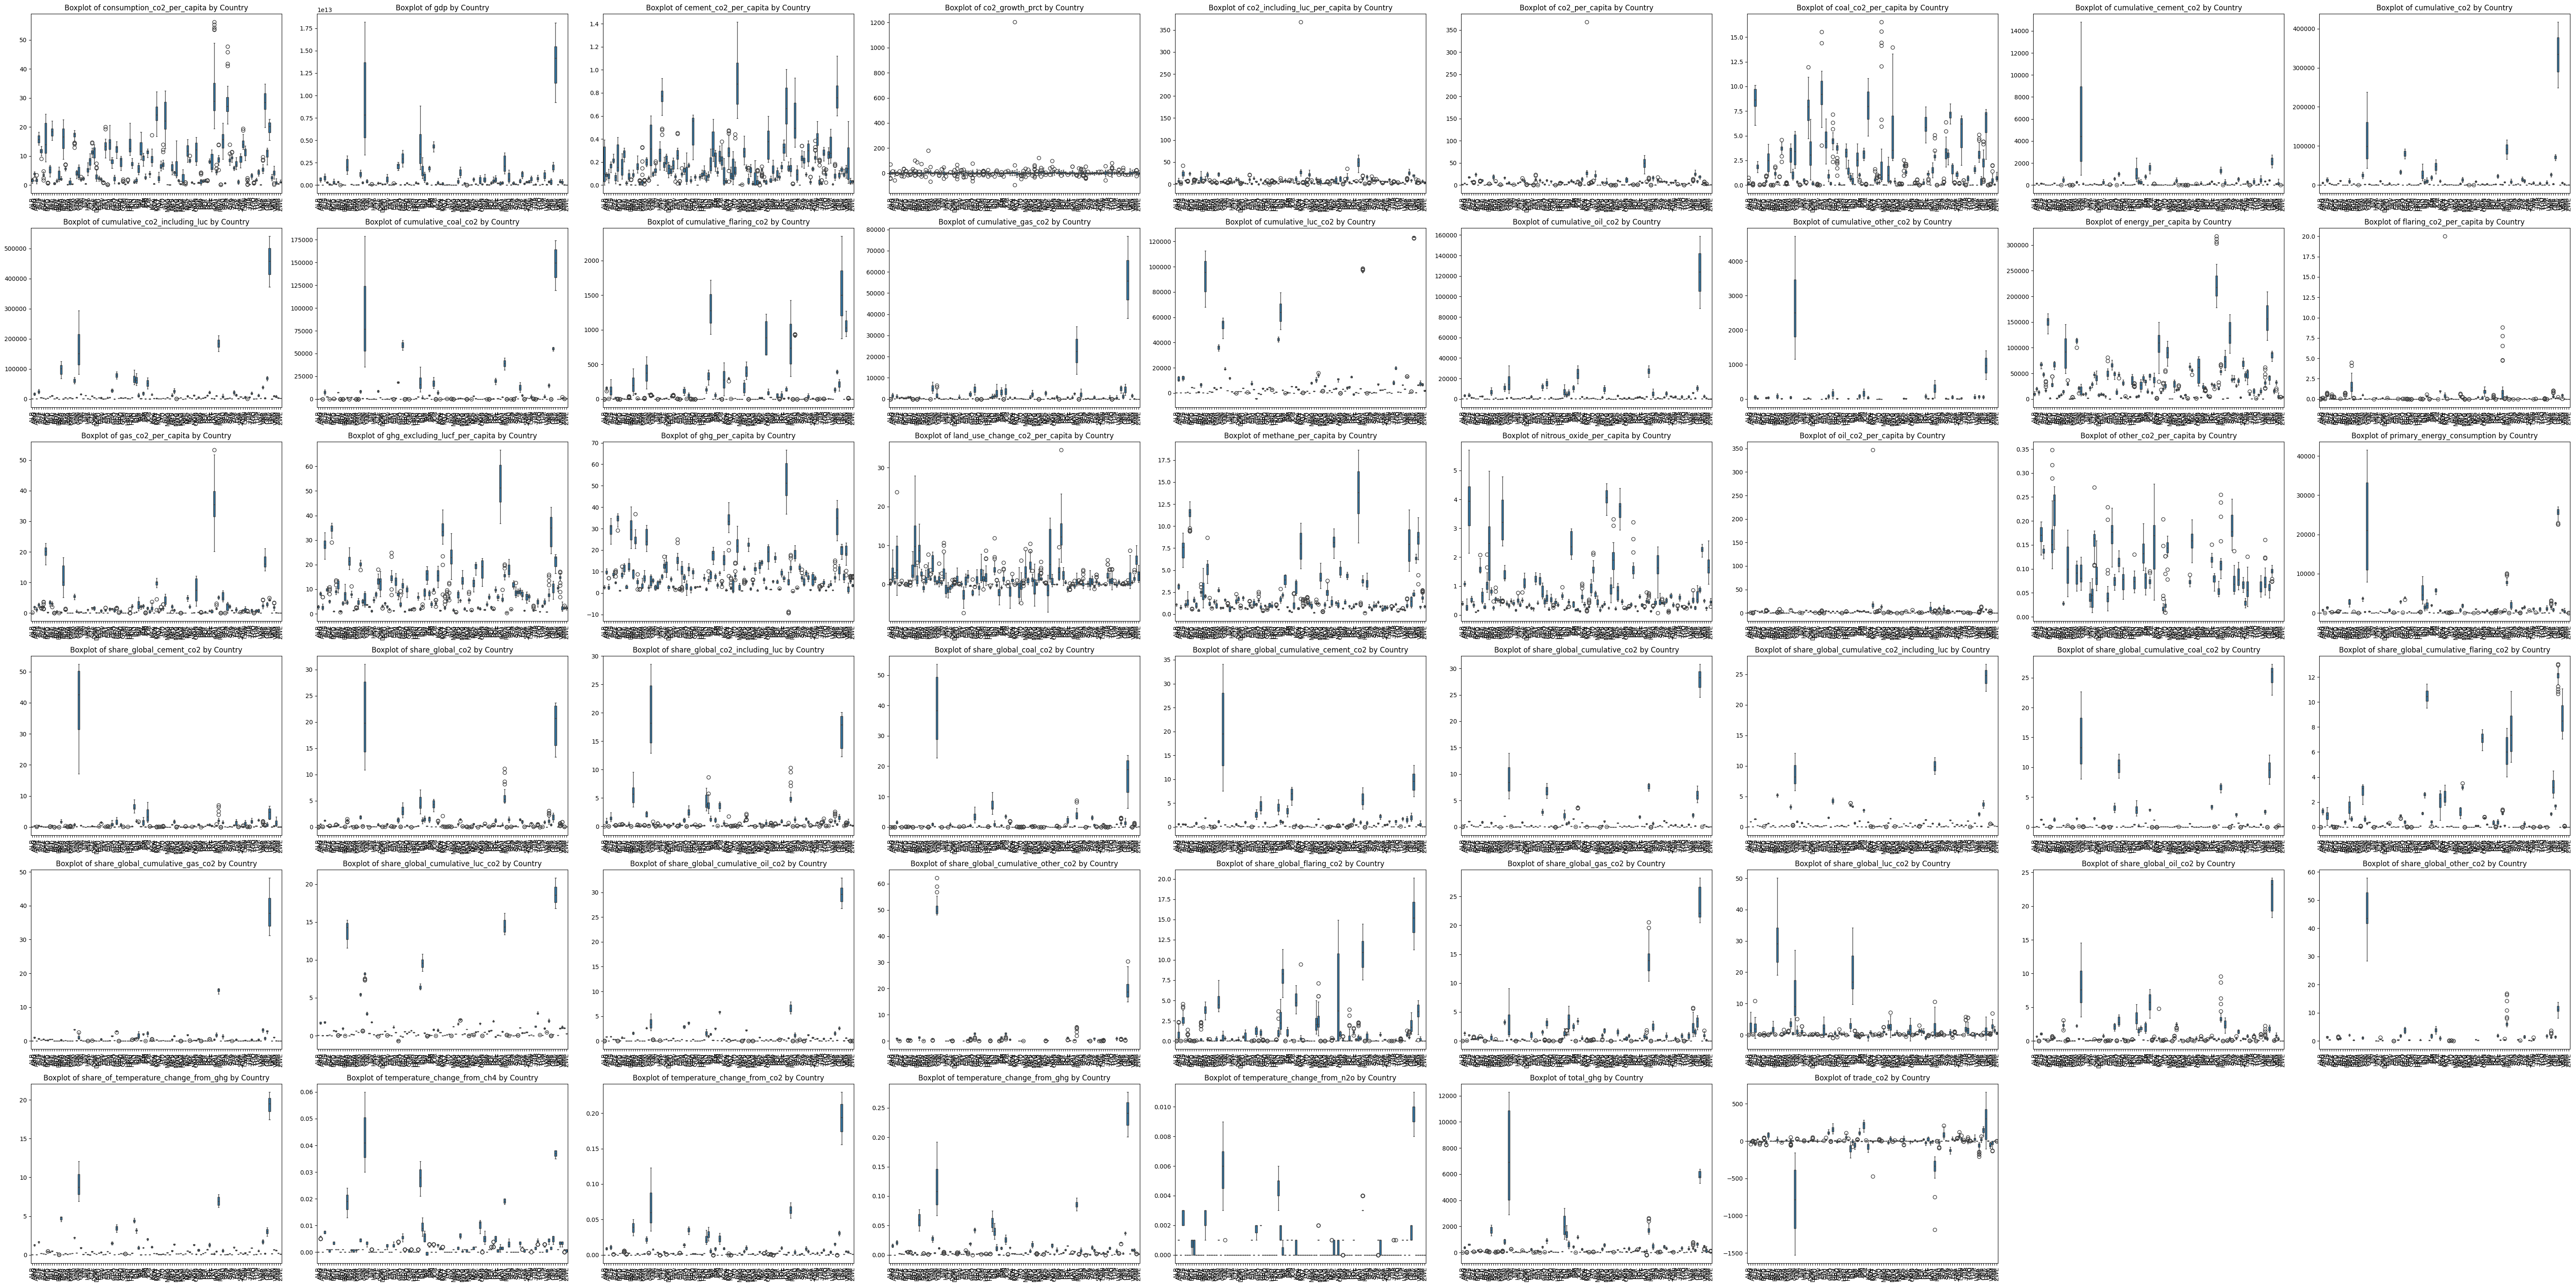

In [15]:
# Plot and save Boxplot graph
variables = data_df.iloc[:, 3:].columns.tolist()
output_folder = 'boxplots'  # Specify the output folder
plot_boxplots(data_df, variables, output_folder)

# Data Processing

## Handling varibales

In [16]:
data = data_df.copy()

In [17]:
# Create a LabelEncoder instance
#label_encoder = LabelEncoder()
# Fit and transform the 'countrie' column
#data['country'] = label_encoder.fit_transform(data['country'])

In [18]:
# Drop inutil variable and chage type of "country" variable
data = data.drop(columns=['iso_code'])
# Replace 'target_column' with the actual name of your CO2 emissions column
# Replace 'feature_columns' with the actual names of your feature columns
target_column = 'consumption_co2_per_capita'
feature_columns = data.columns.difference([target_column])
# Define categorical and numerical features
categorical_features = ['country', 'year']  # Replace with your actual column names
numerical_features = data[feature_columns].columns.difference(categorical_features)

## Missing value

In [19]:
# Identify numeric and non-numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = data.select_dtypes(exclude=[np.number]).columns.tolist()
print("\nList if quantitative variables:")
print(numeric_cols)
print("\nList of qualitative variables:")
print(non_numeric_cols)


List if quantitative variables:
['year', 'consumption_co2_per_capita', 'gdp', 'cement_co2_per_capita', 'co2_growth_prct', 'co2_including_luc_per_capita', 'co2_per_capita', 'coal_co2_per_capita', 'cumulative_cement_co2', 'cumulative_co2', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2', 'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita', 'flaring_co2_per_capita', 'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita', 'land_use_change_co2_per_capita', 'methane_per_capita', 'nitrous_oxide_per_capita', 'oil_co2_per_capita', 'other_co2_per_capita', 'primary_energy_consumption', 'share_global_cement_co2', 'share_global_co2', 'share_global_co2_including_luc', 'share_global_coal_co2', 'share_global_cumulative_cement_co2', 'share_global_cumulative_co2', 'share_global_cumulative_co2_including_luc', 'share_global_cumulative_coal_co2', 'share_global_cumulative_flaring_co2', 'share_global_c

In [20]:
# Calculate the percentage of missing values for each column
missing_percent = (data.isnull().sum() / len(data)) * 100
print("\nPercentage of Missing Values for Each Column:")
print(missing_percent)


Percentage of Missing Values for Each Column:
country                                       0.000000
year                                          0.000000
consumption_co2_per_capita                    0.000000
gdp                                           7.353362
cement_co2_per_capita                         0.658083
co2_growth_prct                               0.057225
co2_including_luc_per_capita                  0.000000
co2_per_capita                                0.000000
coal_co2_per_capita                           0.028612
cumulative_cement_co2                         0.658083
cumulative_co2                                0.000000
cumulative_co2_including_luc                  0.000000
cumulative_coal_co2                           0.028612
cumulative_flaring_co2                        0.028612
cumulative_gas_co2                            0.028612
cumulative_luc_co2                            0.000000
cumulative_oil_co2                            0.028612
cumulative_other_c

<Figure size 1000x500 with 0 Axes>

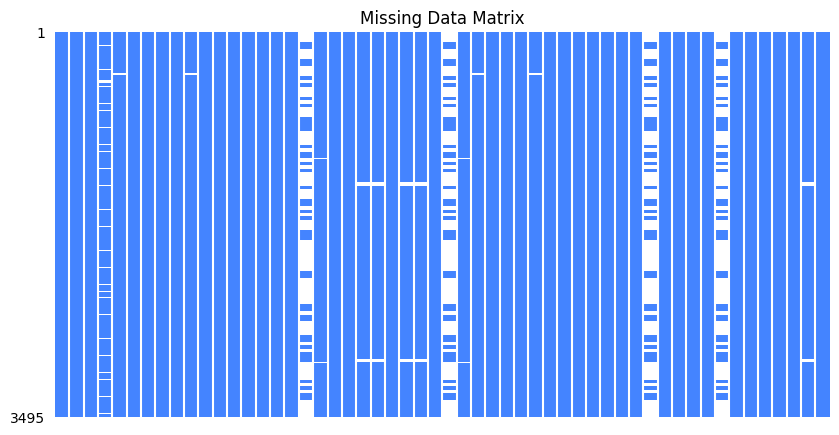

In [21]:
# Visualize missing values
plt.figure(figsize=(10, 5))
msno.matrix(data, sparkline=False, figsize=(10, 5), fontsize=8, color=(0.27, 0.52, 1.0))
plt.title('Missing Data Matrix')
plt.show()

In [22]:
# Calculate the percentage of missing values by country
missing_by_country = data.groupby('country').apply(lambda x: x.isnull().sum() / len(x) * 100)
print("\nPercentage of Missing Values by Country:")
print(missing_by_country)


Percentage of Missing Values by Country:
           country  year  consumption_co2_per_capita       gdp  \
country                                                          
Albania        0.0   0.0                         0.0  6.451613   
Argentina      0.0   0.0                         0.0  6.451613   
Armenia        0.0   0.0                         0.0  6.451613   
Australia      0.0   0.0                         0.0  6.451613   
Austria        0.0   0.0                         0.0  6.451613   
...            ...   ...                         ...       ...   
Uruguay        0.0   0.0                         0.0  6.451613   
Venezuela      0.0   0.0                         0.0  6.666667   
Vietnam        0.0   0.0                         0.0  6.451613   
Zambia         0.0   0.0                         0.0  6.451613   
Zimbabwe       0.0   0.0                         0.0  6.451613   

           cement_co2_per_capita  co2_growth_prct  \
country                                       

### Handling with missing value

In [23]:
# Extract variables where the percentage of missing values is zero
variables_zero_missing = missing_by_country.columns[(missing_by_country == 0).all()].tolist()

# Extract variables where the percentage of missing values is non-zero
variables_non_zero_missing = missing_by_country.columns[(missing_by_country != 0).any()].tolist()

print("\nVariables with Zero Missing Values by Country:")
print(variables_zero_missing)

print("\nVariables with Non-Zero Missing Values by Country:")
print(variables_non_zero_missing)


Variables with Zero Missing Values by Country:
['country', 'year', 'consumption_co2_per_capita', 'co2_including_luc_per_capita', 'co2_per_capita', 'cumulative_co2', 'cumulative_co2_including_luc', 'cumulative_luc_co2', 'land_use_change_co2_per_capita', 'share_global_co2', 'share_global_co2_including_luc', 'share_global_cumulative_co2', 'share_global_cumulative_co2_including_luc', 'share_global_cumulative_luc_co2', 'share_global_luc_co2', 'share_of_temperature_change_from_ghg', 'temperature_change_from_ch4', 'temperature_change_from_co2', 'temperature_change_from_ghg', 'temperature_change_from_n2o', 'trade_co2']

Variables with Non-Zero Missing Values by Country:
['gdp', 'cement_co2_per_capita', 'co2_growth_prct', 'coal_co2_per_capita', 'cumulative_cement_co2', 'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita', 'flaring_co2_per_capita', 'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_

In [24]:
# Extract variables where the percentage of missing values is greater than 10%
# Set the threshold for missing values
threshold = 10
variables_to_drop = missing_percent[missing_percent > threshold].index.tolist()
print("\nVariables to Drop (Missing Percent exceed 10):")
print(variables_to_drop)


Variables to Drop (Missing Percent exceed 10):
['cumulative_other_co2', 'other_co2_per_capita', 'share_global_cumulative_other_co2', 'share_global_other_co2']


In [25]:
# Drop the identified columns from the DataFrame
data_drop = data.drop(columns=variables_to_drop)
#data_drop = data_drop.drop(columns=['iso_code'])

# Drop columns identified in variables_to_drop from test_df
train_drop = train_df.drop(columns=variables_to_drop)
train_drop = train_drop.drop(columns=['iso_code'])

# Drop columns identified in variables_to_drop from test_df
test_drop = test_df.drop(columns=variables_to_drop)
test_drop = test_drop.drop(columns=['iso_code'])

In [26]:
# Function to handling missing value
def impute_missing_values_by_country(data, group_column='country', threshold=10):
    """
    Impute missing values by the mean of each country for columns with missing values <= threshold.
    For remaining missing values, impute with the overall mean.

    Parameters:
    - data: pd.DataFrame, the dataframe to impute
    - group_column: str, the column to group by (default 'country')
    - threshold: float, the threshold percentage for missing values (default 10)

    Returns:
    - data_clean: pd.DataFrame, the dataframe with imputed values
    - mean_values: dict, dictionary of mean values used for imputation
    """
    # Calculate the percentage of missing values for each column
    missing_percent = (data.isnull().sum() / len(data)) * 100

    # Extract variables where the percentage of missing values is less than or equal to the threshold
    variables_to_impute = missing_percent[missing_percent <= threshold].index.tolist()
    print("\nVariables to Impute (Missing Percent <= {}%):".format(threshold))
    print(variables_to_impute)

    # Impute missing values by mean for each country and store means
    mean_values = {}
    data_clean = data.copy()
    for variable in variables_to_impute:
        if variable != group_column:  # Ensure the grouping column is not included in imputation
            group_means = data_clean.groupby(group_column)[variable].transform('mean')
            data_clean[variable] = data_clean[variable].fillna(group_means)
            mean_values[variable] = data_clean.groupby(group_column)[variable].mean()

    # Verify that missing values are handled
    missing_after_imputation = data_clean.isnull().sum()
    print("\nMissing Values After Imputation and Dropping Columns:")
    print(missing_after_imputation)

    # Check for columns that still have missing values
    columns_still_missing = missing_after_imputation[missing_after_imputation > 0].index.tolist()
    print("\nColumns Still Missing Values After Imputation:")
    print(columns_still_missing)

    # Handle columns still missing values by imputing with the overall mean
    for column in columns_still_missing:
        if column != group_column:  # Ensure the grouping column is not included in imputation
            overall_mean = data_clean[column].mean()
            data_clean[column] = data_clean[column].fillna(overall_mean)
            mean_values[column] = {'overall_mean': overall_mean}

    # Verify again that all missing values are handled
    missing_after_final_imputation = data_clean.isnull().sum()
    print("\nMissing Values After Final Imputation:")
    print(missing_after_final_imputation)

    return data_clean, mean_values

In [27]:
# Example usage:
data_clean, _ = impute_missing_values_by_country(data_drop)
train_clean, _ = impute_missing_values_by_country(train_drop)
test_clean, _ = impute_missing_values_by_country(test_drop)


Variables to Impute (Missing Percent <= 10%):
['country', 'year', 'consumption_co2_per_capita', 'gdp', 'cement_co2_per_capita', 'co2_growth_prct', 'co2_including_luc_per_capita', 'co2_per_capita', 'coal_co2_per_capita', 'cumulative_cement_co2', 'cumulative_co2', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2', 'cumulative_oil_co2', 'energy_per_capita', 'flaring_co2_per_capita', 'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita', 'land_use_change_co2_per_capita', 'methane_per_capita', 'nitrous_oxide_per_capita', 'oil_co2_per_capita', 'primary_energy_consumption', 'share_global_cement_co2', 'share_global_co2', 'share_global_co2_including_luc', 'share_global_coal_co2', 'share_global_cumulative_cement_co2', 'share_global_cumulative_co2', 'share_global_cumulative_co2_including_luc', 'share_global_cumulative_coal_co2', 'share_global_cumulative_flaring_co2', 'share_global_cumulative_gas_co2', 'sh

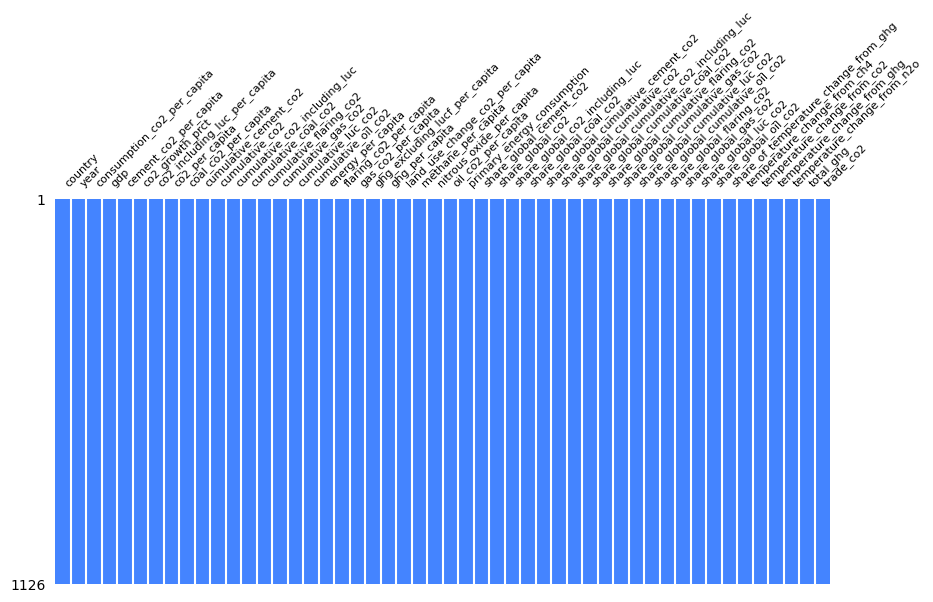

In [28]:
# Visualize missing values after imputation
msno.matrix(test_clean, sparkline=False, figsize=(10, 5), fontsize=8, color=(0.27, 0.52, 1.0))
plt.show()

In [29]:
# Save mean values DataFrame for deployment
data_clean.to_csv('data_clean.csv')
train_clean.to_csv('train_clean.csv')
test_clean.to_csv('test_clean.csv')

## Outliers

In [30]:
# Function to detect outliers
def detect_outliers_iqr_by_country(data, group_column='country'):
    outlier_indices = []
    outlier_summary = {}

    grouped = data.groupby(group_column)

    for country, group_data in grouped:
        for column in group_data.select_dtypes(include=['float64', 'int64']).columns:
            Q1 = group_data[column].quantile(0.25)
            Q3 = group_data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = group_data[(group_data[column] < lower_bound) | (group_data[column] > upper_bound)].index
            outlier_indices.extend(outliers)
            outlier_summary[(country, column)] = 'Yes' if not outliers.empty else 'No'

    outlier_indices = list(set(outlier_indices))  # Remove duplicates
    return outlier_indices, outlier_summary

In [31]:
# Assuming 'data' is your DataFrame containing 'country' and numerical columns
# Replace 'data' with your actual DataFrame and adjust parameters as needed
outlier_indices, outlier_summary = detect_outliers_iqr_by_country(data_clean, group_column='country')

# Print or use outlier_indices and outlier_summary as needed
print("Outlier Indices:", outlier_indices)
print("\nOutlier Summary:")
for key, value in outlier_summary.items():
    print(f"Country: {key[0]}, Column: {key[1]} - Outlier Detected: {value}")

Streaming output truncated to the last 5000 lines.
Country: Benin, Column: total_ghg - Outlier Detected: No
Country: Benin, Column: trade_co2 - Outlier Detected: No
Country: Bolivia, Column: year - Outlier Detected: No
Country: Bolivia, Column: consumption_co2_per_capita - Outlier Detected: No
Country: Bolivia, Column: gdp - Outlier Detected: No
Country: Bolivia, Column: cement_co2_per_capita - Outlier Detected: No
Country: Bolivia, Column: co2_growth_prct - Outlier Detected: Yes
Country: Bolivia, Column: co2_including_luc_per_capita - Outlier Detected: No
Country: Bolivia, Column: co2_per_capita - Outlier Detected: No
Country: Bolivia, Column: coal_co2_per_capita - Outlier Detected: Yes
Country: Bolivia, Column: cumulative_cement_co2 - Outlier Detected: No
Country: Bolivia, Column: cumulative_co2 - Outlier Detected: No
Country: Bolivia, Column: cumulative_co2_including_luc - Outlier Detected: No
Country: Bolivia, Column: cumulative_coal_co2 - Outlier Detected: Yes
Country: Bolivia, Co

### Handling with outliers

In [32]:
# Function to handling outliers
def handle_outliers_by_country(data, outlier_indices, method='remove', group_column='country'):
    data_cleaned = data.copy()

    if method == 'remove':
        data_cleaned = data_cleaned.drop(outlier_indices)
    elif method == 'cap':
        grouped = data_cleaned.groupby(group_column)
        for country, group_data in grouped:
            for column in group_data.select_dtypes(include=['float64', 'int64']).columns:
                Q1 = group_data[column].quantile(0.25)
                Q3 = group_data[column].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                data_cleaned.loc[group_data.index, column] = np.where(group_data[column] < lower_bound, lower_bound, group_data[column])
                data_cleaned.loc[group_data.index, column] = np.where(group_data[column] > upper_bound, upper_bound, group_data[column])
    elif method == 'impute':
        grouped = data_cleaned.groupby(group_column)
        for country, group_data in grouped:
            for column in group_data.select_dtypes(include=['float64', 'int64']).columns:
                median = group_data[column].median()
                data_cleaned.loc[group_data.index.intersection(outlier_indices), column] = median

    return data_cleaned

In [33]:
# Handle outliers by imputing them
data_o_cleaned_impute = handle_outliers_by_country(data_clean, outlier_indices, method='impute')

# Print summary of each method
print("Data after imputing outliers:\n", data_o_cleaned_impute.describe())

Data after imputing outliers:
               year  consumption_co2_per_capita           gdp  \
count  3495.000000                 3495.000000  3.495000e+03   
mean   2005.088269                    6.107955  6.277325e+11   
std       5.707676                    6.665289  1.739393e+12   
min    1990.000000                    0.036000  3.965511e+09   
25%    2003.000000                    0.959500  3.463262e+10   
50%    2005.000000                    3.683000  1.270000e+11   
75%    2007.000000                    9.421500  4.443276e+11   
max    2020.000000                   47.745000  1.810000e+13   

       cement_co2_per_capita  co2_growth_prct  co2_including_luc_per_capita  \
count            3495.000000      3495.000000                   3495.000000   
mean                0.150426         2.341381                      6.767940   
std                 0.168124         6.290875                      7.203432   
min                 0.000000       -29.248000                     -2.136000 

In [34]:
# Handle outliers by imputing them (train data)
outlier_indices_tr, outlier_summary_tr = detect_outliers_iqr_by_country(train_clean, group_column='country')
# Handle outliers by imputing them
train_o_cleaned_impute = handle_outliers_by_country(train_clean, outlier_indices_tr, method='impute')

# Print summary of each method
print("Data train after imputing outliers:\n", train_o_cleaned_impute.describe())

Data train after imputing outliers:
               year  consumption_co2_per_capita           gdp  \
count  2369.000000                 2369.000000  2.369000e+03   
mean   2000.046011                    6.231067  5.155882e+11   
std       3.607892                    7.253943  1.427900e+12   
min    1990.000000                    0.052000  3.631866e+09   
25%    1999.000000                    0.917000  2.674026e+10   
50%    2000.000000                    3.461000  1.020000e+11   
75%    2001.000000                    9.526000  3.490000e+11   
max    2010.000000                   56.141000  1.540000e+13   

       cement_co2_per_capita  co2_growth_prct  co2_including_luc_per_capita  \
count            2369.000000      2369.000000                   2369.000000   
mean                0.145262         2.602515                      6.970961   
std                 0.174295         6.315438                      7.806696   
min                 0.000000       -32.520000                     -2.1

In [35]:
# Handle outliers by imputing them(test data)
outlier_indices_ts, outlier_summary_ts = detect_outliers_iqr_by_country(test_clean, group_column='country')
# Handle outliers by imputing them
test_o_cleaned_impute = handle_outliers_by_country(test_clean, outlier_indices_ts, method='impute')

# Print summary of each method
print("Data test after imputing outliers:\n", test_o_cleaned_impute.describe())

Data test after imputing outliers:
              year  consumption_co2_per_capita           gdp  \
count  1126.00000                 1126.000000  1.126000e+03   
mean   2015.42762                    6.179246  8.779851e+11   
std       1.41039                    6.334809  2.320971e+12   
min    2011.00000                    0.057000  8.791743e+09   
25%    2015.50000                    1.498500  5.579926e+10   
50%    2015.50000                    4.260500  2.055000e+11   
75%    2015.87500                    8.913000  7.350000e+11   
max    2020.00000                   47.781000  1.820000e+13   

       cement_co2_per_capita  co2_growth_prct  co2_including_luc_per_capita  \
count            1126.000000      1126.000000                   1126.000000   
mean                0.166803         1.964914                      6.195833   
std                 0.163529         6.254868                      6.294792   
min                 0.000000       -36.857000                     -0.390000   
2

In [36]:
# Export cleaned data
export_to_excel(data_o_cleaned_impute, 'data_handling.xlsx')
export_to_excel(train_o_cleaned_impute, 'train_handling.xlsx')
export_to_excel(test_o_cleaned_impute, 'test_handling.xlsx')

## Multicollinearity

In [37]:
# Ensure data types are correct before VIF calculation
print(data_o_cleaned_impute.dtypes)

country                                       object
year                                         float64
consumption_co2_per_capita                   float64
gdp                                          float64
cement_co2_per_capita                        float64
co2_growth_prct                              float64
co2_including_luc_per_capita                 float64
co2_per_capita                               float64
coal_co2_per_capita                          float64
cumulative_cement_co2                        float64
cumulative_co2                               float64
cumulative_co2_including_luc                 float64
cumulative_coal_co2                          float64
cumulative_flaring_co2                       float64
cumulative_gas_co2                           float64
cumulative_luc_co2                           float64
cumulative_oil_co2                           float64
energy_per_capita                            float64
flaring_co2_per_capita                       f

In [38]:
# Check for NaN and inf values
print("NaN values:")
print(data_o_cleaned_impute.isnull().sum())


NaN values:
country                                      0
year                                         0
consumption_co2_per_capita                   0
gdp                                          0
cement_co2_per_capita                        0
co2_growth_prct                              0
co2_including_luc_per_capita                 0
co2_per_capita                               0
coal_co2_per_capita                          0
cumulative_cement_co2                        0
cumulative_co2                               0
cumulative_co2_including_luc                 0
cumulative_coal_co2                          0
cumulative_flaring_co2                       0
cumulative_gas_co2                           0
cumulative_luc_co2                           0
cumulative_oil_co2                           0
energy_per_capita                            0
flaring_co2_per_capita                       0
gas_co2_per_capita                           0
ghg_excluding_lucf_per_capita                0
g

In [39]:
# Check for infinity values excluding the 'country' column
print("Infinity values (excluding 'country'):")
print(np.isinf(data_o_cleaned_impute.drop(columns=['country'])).sum())

Infinity values (excluding 'country'):
year                                         0
consumption_co2_per_capita                   0
gdp                                          0
cement_co2_per_capita                        0
co2_growth_prct                              0
co2_including_luc_per_capita                 0
co2_per_capita                               0
coal_co2_per_capita                          0
cumulative_cement_co2                        0
cumulative_co2                               0
cumulative_co2_including_luc                 0
cumulative_coal_co2                          0
cumulative_flaring_co2                       0
cumulative_gas_co2                           0
cumulative_luc_co2                           0
cumulative_oil_co2                           0
energy_per_capita                            0
flaring_co2_per_capita                       0
gas_co2_per_capita                           0
ghg_excluding_lucf_per_capita                0
ghg_per_capita       

In [45]:
# Function to compute VIF value
def calculate_vif(data):
    # Create a DataFrame to store VIF results
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    return vif_data

In [46]:
# Calculate VIF for data_o_cleaned_impute
d_test = data_o_cleaned_impute.drop(columns=['country'])
vif_results = calculate_vif(d_test)

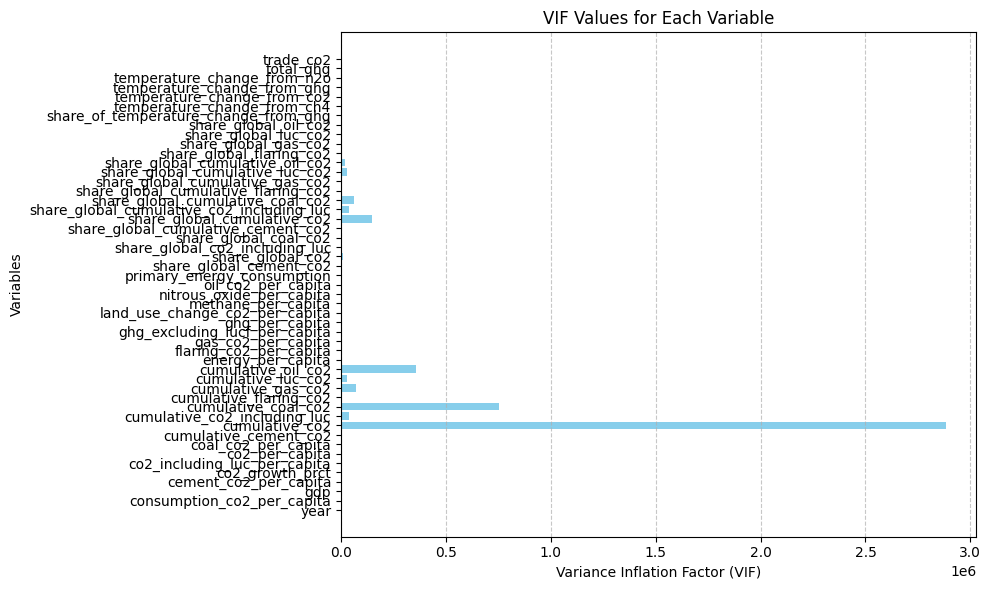

In [47]:
# Plotting the VIF results
plt.figure(figsize=(10, 6))
plt.barh(vif_results["Variable"], vif_results["VIF"], color='skyblue')
plt.xlabel('Variance Inflation Factor (VIF)')
plt.ylabel('Variables')
plt.title('VIF Values for Each Variable')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

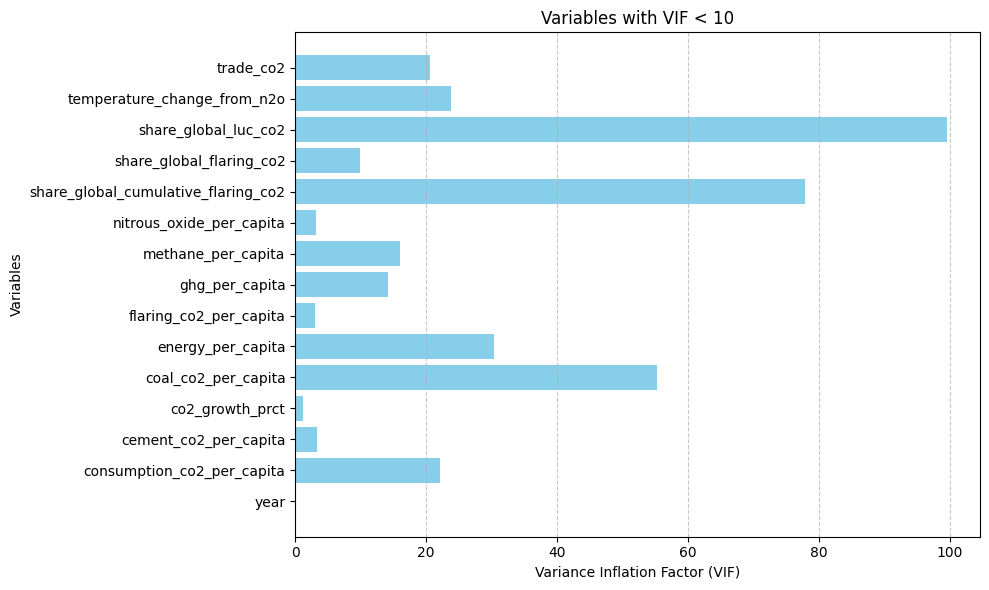

In [48]:
# Filter variables where VIF < 10
vif_filtered = vif_results[vif_results['VIF'] < 100]

# Plotting the filtered VIF results
plt.figure(figsize=(10, 6))
plt.barh(vif_filtered["Variable"], vif_filtered["VIF"], color='skyblue')
plt.xlabel('Variance Inflation Factor (VIF)')
plt.ylabel('Variables')
plt.title('Variables with VIF < 10')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Handling multicollinearity in a dataset is crucial for improving the stability and interpretability of regression models. Here are several strategies to manage multicollinearity:
1. Feature Selection

    Correlation Matrix: Examine the correlation matrix among variables. Variables with high pairwise correlations may indicate multicollinearity.
    Variance Inflation Factor (VIF): Calculate VIF for each variable. Variables with high VIF values (typically > 10) indicate multicollinearity.

2. Methods to Handle Multicollinearity
a. Remove Highly Correlated Variables

    Identify and remove variables that are highly correlated with each other. Retain the variable that is more theoretically meaningful or has a stronger relationship with the dependent variable.

b. Principal Component Analysis (PCA)

    Use PCA to transform correlated variables into a smaller set of uncorrelated components. This reduces multicollinearity but may make interpretation more challenging.

c. Ridge Regression

    Ridge regression adds a penalty to the regression coefficients to reduce their size. This can mitigate multicollinearity effects and improve model stability.

d. Variable Transformation

    Centering: Subtract the mean from each variable, making the variables more comparable.
    Scaling: Divide each variable by its standard deviation, putting them on a similar scale.
    Variable Combination: Create new variables by combining correlated variables or using interactions.

e. Lasso Regression

    Lasso regression includes a penalty that encourages some coefficients to be exactly zero. This can automatically perform variable selection and reduce multicollinearity.

f. Cross-validation

    Use cross-validation techniques to assess model performance and choose the best subset of variables or regularization parameters that minimize multicollinearity effects.

=> In our study, the test for multicollinearity was conducted after feature selection and data scaling (mean normalization). The results indicated that multicollinearity was not present in the data.

# Data transformation

In [49]:
# Function to get standard data
def standardize_data(data, method='min-max'):
    """
    Standardizes numerical data using specified methods.

    Parameters:
    - data (DataFrame): Input DataFrame with numerical columns to be standardized.
    - method (str): Method of standardization to apply. Possible values:
      - 'standard': Standardization (z-score normalization).
      - 'min-max': Min-Max scaling.
      - 'robust': Robust scaling (for handling outliers).

    Returns:
    - DataFrame: Standardized DataFrame.
    """
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'min-max':
        scaler = MinMaxScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid method. Please choose one of: 'standard', 'min-max', 'robust'.")

    # Fit and transform the data
    data_scaled = data.copy()
    data_scaled[numeric_cols] = scaler.fit_transform(data[numeric_cols])

    return data_scaled

In [50]:
# Apply standardization by country
standardized_data = data_o_cleaned_impute.groupby('country').apply(standardize_data).reset_index(drop=True)

# Apply standardization by country train data
standardized_train = train_o_cleaned_impute.groupby('country').apply(standardize_data).reset_index(drop=True)

# Apply standardization by country test data
standardized_test = test_o_cleaned_impute.groupby('country').apply(standardize_data).reset_index(drop=True)

In [51]:
# Save the standardized data to a new CSV file
data_modeling = standardized_data.drop(columns=['country'])
train_modeling = standardized_train.drop(columns=['country'])
test_modeling = standardized_test.drop(columns=['country'])

data_modeling.to_csv('data_modeling.csv', index=False)
train_modeling.to_csv('train_modeling.csv', index=False)
test_modeling.to_csv('test_modeling.csv', index=False)

# Data spliting

In [52]:
# Define the target variable
target_variable = 'consumption_co2_per_capita'

# Separate the features and the target variable in the training set
X_train = train_modeling.drop(columns=[target_variable])
y_train = train_modeling[target_variable]

# Separate the features and the target variable in the testing set
X_test = test_modeling.drop(columns=[target_variable])
y_test = test_modeling[target_variable]

# Verify the separation
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2369, 48)
y_train shape: (2369,)
X_test shape: (1126, 48)
y_test shape: (1126,)


# LIME method

To add different measures for selecting variables in the script, we can incorporate feature selection techniques before training the models. Some common feature selection techniques include:

    Univariate Selection: Selecting features based on statistical tests.
    Recursive Feature Elimination (RFE): Recursively removing least important features.
    Feature Importance from Tree-Based Models: Using feature importance scores from models like Random Forest.

In [54]:
X_train.head(3)

year       gdp  cement_co2_per_capita  co2_growth_prct  \
0  0.454545  0.355876               0.326531         0.613945   
1  0.454545  0.355876               0.326531         0.613945   
2  0.454545  0.355876               0.326531         0.613945   

   co2_including_luc_per_capita  co2_per_capita  coal_co2_per_capita  \
0                      0.345865        0.779807             0.571429   
1                      0.345865        0.779807             0.571429   
2                      0.345865        0.779807             0.571429   

   cumulative_cement_co2  cumulative_co2  cumulative_co2_including_luc  ...  \
0               0.235175        0.324091                      0.301528  ...   
1               0.235175        0.324091                      0.301528  ...   
2               0.235175        0.324091                      0.301528  ...   

   share_global_gas_co2  share_global_luc_co2  share_global_oil_co2  \
0                   1.0              0.296875              0.636364   
1                   1.0              0.296875              0.636364   
2                   1.0              0.296875              0.636364   

   share_of_temperature_change_from_ghg  temperature_change_from_ch4  \
0                                   0.5                          0.0   
1                                   0.5                          0.0   
2                                   0.5                          0.0   

   temperature_change_from_co2  temperature_change_from_ghg  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   

   temperature_change_from_n2o  total_ghg  trade_co2  
0                          0.0    0.63388   0.442433  
1                          0.0    0.63388   0.442433  
2                          0.0    0.63388   0.442433  

[3 rows x 48 columns]

In [55]:
# Split the data into X and y
X = X_train.copy()
y = y_train.copy()

In [56]:
# Univariate Selection
select_k_best = SelectKBest(score_func=f_regression, k='all')
select_k_best.fit(X, y)
univariate_scores = select_k_best.scores_

In [57]:
# Recursive Feature Elimination (RFE)
model_for_rfe = LinearRegression()
rfe = RFE(model_for_rfe, n_features_to_select=1, step=1)
rfe.fit(X, y)
rfe_ranking = rfe.ranking_

In [58]:
# Feature Importance from Random Forest
model_for_importance = RandomForestRegressor(n_estimators=100, random_state=42)
model_for_importance.fit(X, y)
importances = model_for_importance.feature_importances_
feature_importances_rank = np.argsort(importances)[::-1]

In [59]:
# Create a DataFrame to store ranks
ranking_table = pd.DataFrame({
    'Variable': X.columns,
    'Univariate Rank': univariate_scores.argsort()[::-1].argsort() + 1,
    'RFE Rank': rfe_ranking,
    'Feature Importance Rank': feature_importances_rank.argsort() + 1
})

In [60]:
# LIME explanations for multiple instances
lime_feature_counts = {feature: 0 for feature in X.columns}
explainer = lime_tabular.LimeTabularExplainer(
    X.values,
    feature_names=list(X.columns),
    mode='regression'
)

# Choose a set of instances for LIME explanations
num_instances = 10  # Number of instances to explain
for instance_idx in range(num_instances):
    instance = X.iloc[instance_idx].values
    exp = explainer.explain_instance(instance, model_for_importance.predict, num_features=len(X.columns))
    lime_features = [feature[0].split()[0] for feature in exp.as_list()]  # Extract raw feature names
    for feature in lime_features:
        if feature in lime_feature_counts:
            lime_feature_counts[feature] += 1

# Convert LIME feature counts to ranks
lime_ranking = pd.Series(lime_feature_counts).rank(ascending=False).astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature name

In [61]:
# Add LIME Rank to the ranking table
ranking_table['LIME Rank'] = ranking_table['Variable'].map(lime_ranking)

# Add a voting column to aggregate ranks
ranking_table['Total Rank'] = ranking_table[['Univariate Rank', 'RFE Rank', 'Feature Importance Rank', 'LIME Rank']].sum(axis=1)
ranking_table['Vote Rank'] = ranking_table['Total Rank'].rank(method='min')

# Sort the table by the final rank
ranking_table.sort_values('Vote Rank', inplace=True)

ranking_table.head(10)


Variable  Univariate Rank  RFE Rank  \
5                 co2_per_capita                1         3   
47                     trade_co2                2         4   
1                            gdp                3        15   
11        cumulative_flaring_co2               20         9   
15             energy_per_capita                6        19   
9   cumulative_co2_including_luc               13         8   
6            coal_co2_per_capita               22         7   
26              share_global_co2                8        16   
38          share_global_gas_co2               24        13   
8                 cumulative_co2                7         1   

    Feature Importance Rank  LIME Rank  Total Rank  Vote Rank  
5                         1          7          12        1.0  
47                        2         34          42        2.0  
1                         5         23          46        3.0  
11                       17          7          53        4.0  
15                        9         23          57        5.0  
9                        35          7          63        6.0  
6                         3         34          66        7.0  
26                       12         34          70        8.0  
38                       29          7          73        9.0  
8                        43         23          74       10.0

In [62]:
# Ensure 'ranking_table' is sorted by 'LIME Rank' in ascending order
ranking_table_sorted = ranking_table.sort_values(by='LIME Rank', ascending=True)

# Melt the DataFrame to long format for easier plotting
ranking_melted = ranking_table_sorted.melt(id_vars=['Variable'], value_vars=['LIME Rank', 'Vote Rank'],
                                           var_name='Rank Type', value_name='Rank')

<Figure size 1200x800 with 0 Axes>

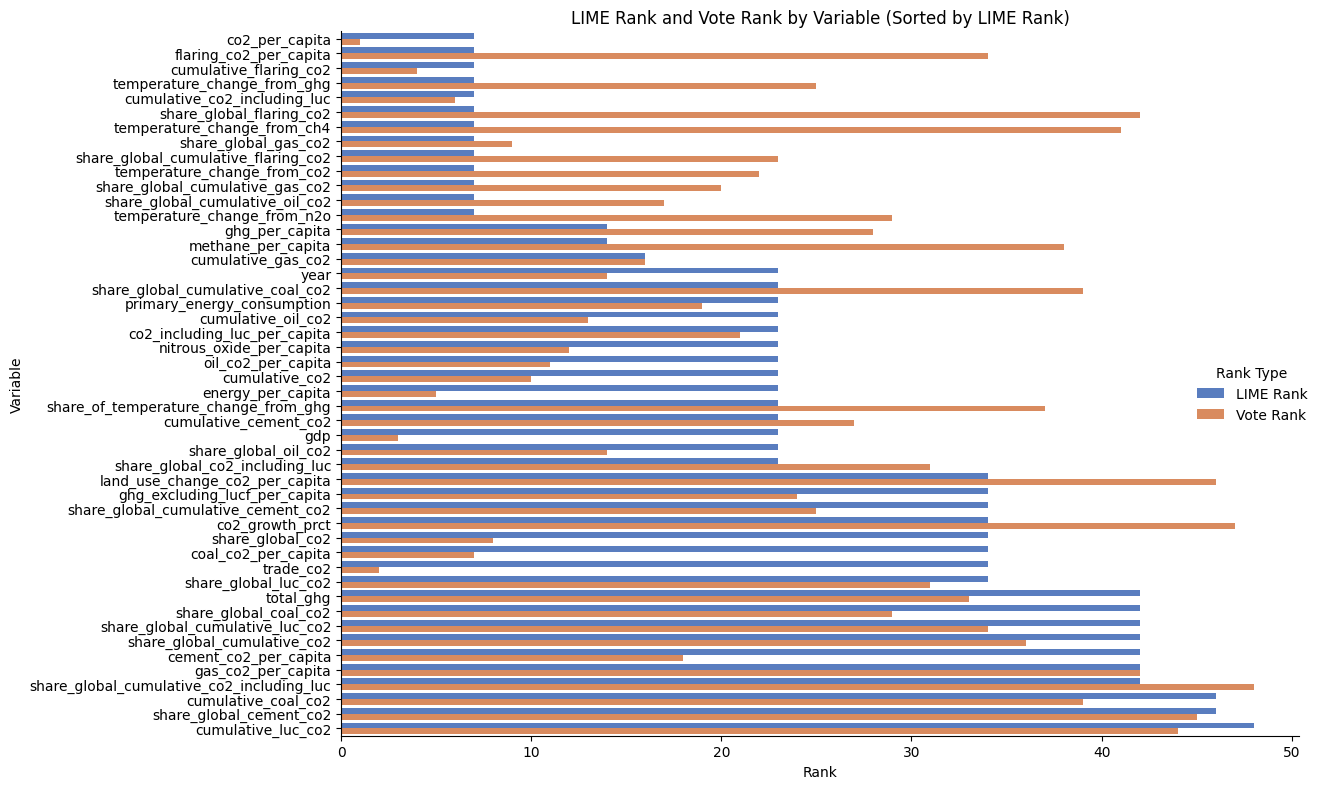

In [63]:
# Set the figure size for better readability
plt.figure(figsize=(12, 8))

# Create a bar plot with side-by-side bars
plot = sns.catplot(
    x='Rank',
    y='Variable',
    hue='Rank Type',
    data=ranking_melted,
    kind='bar',
    height=8,
    aspect=1.5,
    palette='muted'
)

# Add labels and title
plt.xlabel('Rank')
plt.ylabel('Variable')
plt.title('LIME Rank and Vote Rank by Variable (Sorted by LIME Rank)')

# Adjust the layout for better fit
plt.tight_layout()

# Save the plot as an image
plot.savefig('lime_vote_rank_by_variable.png')

# Show the plot
plt.show()


In [64]:
# Define models using the top features based on voting rank
top_features = ranking_table.nsmallest(20, 'Vote Rank')['Variable']

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

In [65]:
models = {
    'Linear Regression': LinearRegression(),
    'PCA + Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=10)),
        ('lr', LinearRegression())
    ]),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

# Train each model using top features
for name, model in models.items():
    model.fit(X_train_top, y_train)
    print(f"{name} model trained.")

# Create a LIME explainer for regression using the top features
explainer = lime_tabular.LimeTabularExplainer(
    X_train_top.values,
    feature_names=list(X_train_top.columns),
    mode='regression'
)

# Choose an instance for which you want to explain the prediction
instance_idx = 0  # You can choose any index from your dataset
instance = X_train_top.iloc[instance_idx].values  # Use .values to convert to a NumPy array

Linear Regression model trained.
PCA + Linear Regression model trained.
Random Forest model trained.
XGBoost model trained.
Decision Tree model trained.


Explaining predictions for Linear Regression model.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names


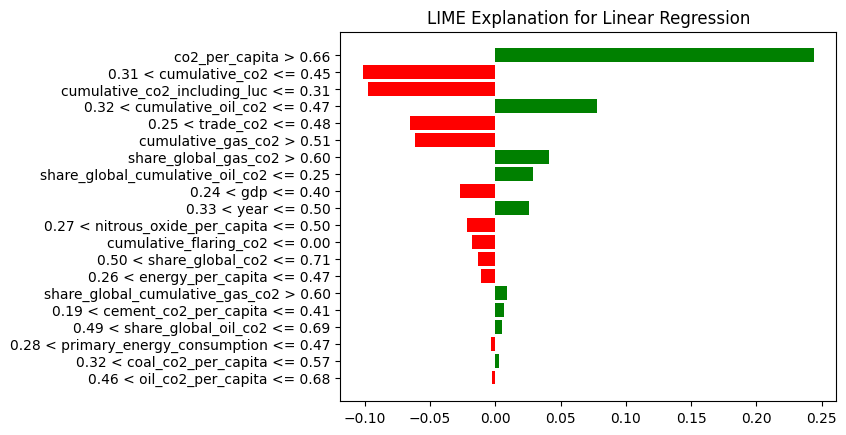

Explaining predictions for PCA + Linear Regression model.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names


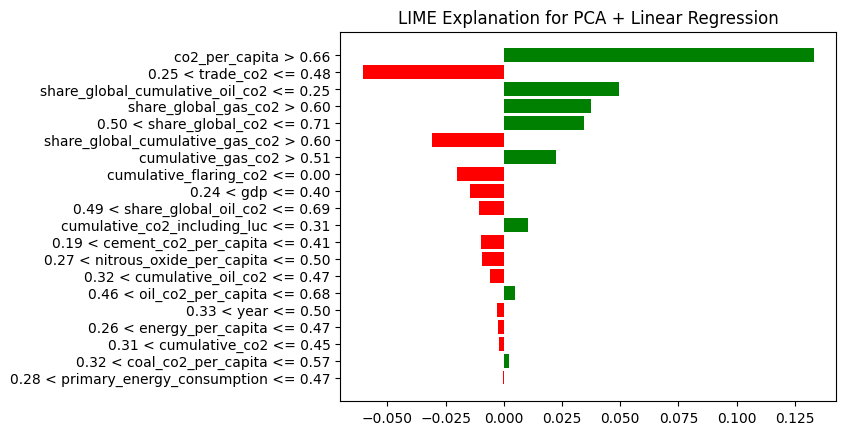

Explaining predictions for Random Forest model.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names


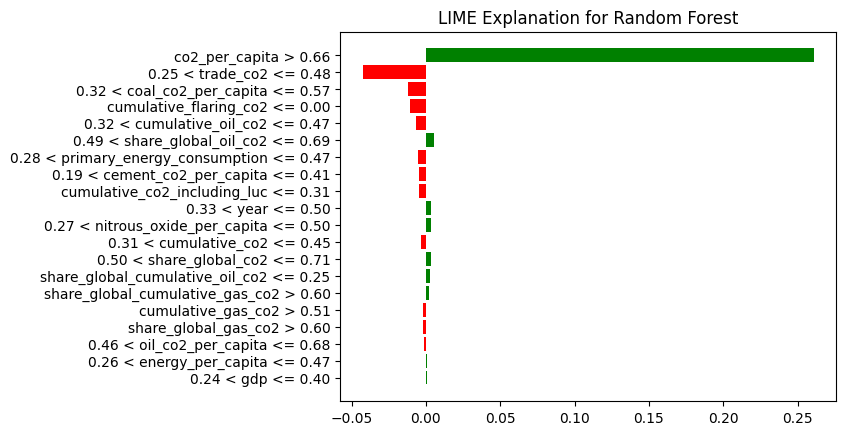

Explaining predictions for XGBoost model.


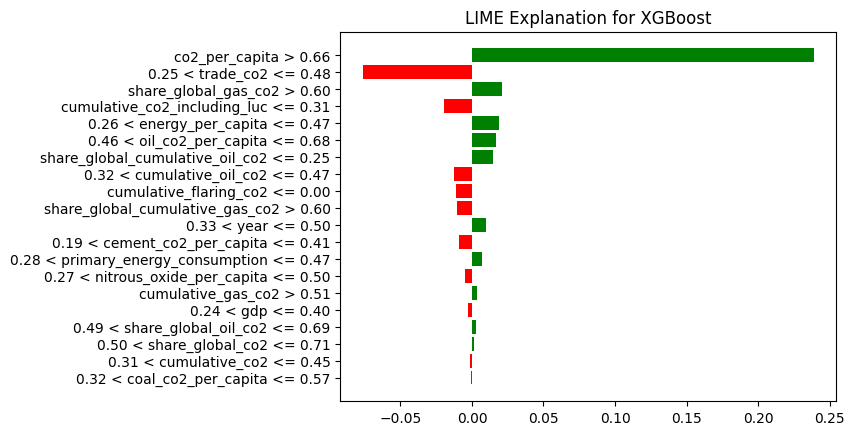

Explaining predictions for Decision Tree model.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


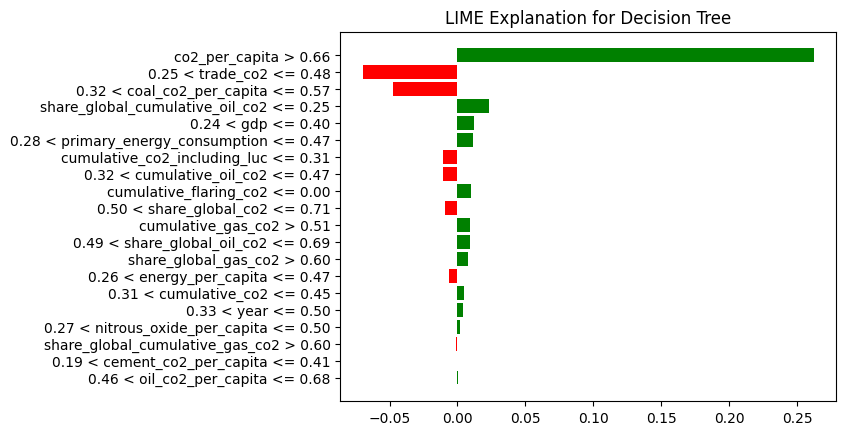

In [66]:
# Explain the prediction for the chosen instance for each model
for name, model in models.items():
    print(f"Explaining predictions for {name} model.")
    exp = explainer.explain_instance(instance, model.predict, num_features=len(top_features))

    # Plot the explanation
    exp.as_pyplot_figure()
    plt.title(f"LIME Explanation for {name}")
    plt.show()

In [67]:
ranking_table.to_excel("ranking_table.xlsx", index=False)

# Modeling

In [68]:
# Sort 'ranking_table' by 'LIME Rank' in ascending order
ranking_table_sorted = ranking_table.sort_values(by='LIME Rank', ascending=True)

In [69]:
ranking_table_sorted.head(19)

Variable  Univariate Rank  RFE Rank  \
5                        co2_per_capita                1         3   
16               flaring_co2_per_capita               30        37   
11               cumulative_flaring_co2               20         9   
44          temperature_change_from_ghg               25        26   
9          cumulative_co2_including_luc               13         8   
37             share_global_flaring_co2               42        36   
42          temperature_change_from_ch4               32        38   
38                 share_global_gas_co2               24        13   
33  share_global_cumulative_flaring_co2               43        10   
43          temperature_change_from_co2               27        35   
34      share_global_cumulative_gas_co2               28        20   
36      share_global_cumulative_oil_co2               34        27   
45          temperature_change_from_n2o               35        23   
19                       ghg_per_capita               23        40   
21                   methane_per_capita               41        44   
12                   cumulative_gas_co2               17        14   
0                                  year               11         5   
32     share_global_cumulative_coal_co2               40        39   
24           primary_energy_consumption                9        47   

    Feature Importance Rank  LIME Rank  Total Rank  Vote Rank  
5                         1          7          12        1.0  
16                       42          7         116       34.0  
11                       17          7          53        4.0  
44                       46          7         104       25.0  
9                        35          7          63        6.0  
37                       41          7         126       42.0  
42                       47          7         124       41.0  
38                       29          7          73        9.0  
33                       39          7          99       23.0  
43                       28          7          97       22.0  
34                       40          7          95       20.0  
36                       19          7          87       17.0  
45                       48          7         113       29.0  
19                       31         14         108       28.0  
21                       21         14         120       38.0  
12                       38         16          85       16.0  
0                        44         23          83       14.0  
32                       20         23         122       39.0  
24                       11         23          90       19.0

In [70]:
# Define models using the top features based on voting rank
top_features = ranking_table_sorted.nsmallest(20, 'LIME Rank')['Variable']

In [71]:
list(top_features)

['co2_per_capita',
 'flaring_co2_per_capita',
 'cumulative_flaring_co2',
 'temperature_change_from_ghg',
 'cumulative_co2_including_luc',
 'share_global_flaring_co2',
 'temperature_change_from_ch4',
 'share_global_gas_co2',
 'share_global_cumulative_flaring_co2',
 'temperature_change_from_co2',
 'share_global_cumulative_gas_co2',
 'share_global_cumulative_oil_co2',
 'temperature_change_from_n2o',
 'ghg_per_capita',
 'methane_per_capita',
 'cumulative_gas_co2',
 'year',
 'share_global_cumulative_coal_co2',
 'primary_energy_consumption',
 'cumulative_oil_co2']

In [72]:
# Filter the features that exist in both the DataFrame and the list
common_features = set(X_train.columns) & set(top_features)

X_train_top = X_train[list(common_features)]
X_test_top = X_test[list(common_features)]

In [ ]:
# Check the types and shapes of the datasets
print(f"X_train type: {type(X_train)}, shape: {X_train_top.shape}")
print(f"y_train type: {type(y_train)}, shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}, shape: {X_test_top.shape}")
print(f"y_test type: {type(y_test)}, shape: {y_test.shape}")

# Check for any missing values
print(f"Missing values in X_train: {X_train_top.isnull().sum().sum()}")
print(f"Missing values in y_train: {y_train.isnull().sum()}")
print(f"Missing values in X_test: {X_test_top.isnull().sum().sum()}")
print(f"Missing values in y_test: {y_test.isnull().sum()}")


X_train type: <class 'pandas.core.frame.DataFrame'>, shape: (2369, 20)
y_train type: <class 'pandas.core.series.Series'>, shape: (2369,)
X_test type: <class 'pandas.core.frame.DataFrame'>, shape: (1126, 20)
y_test type: <class 'pandas.core.series.Series'>, shape: (1126,)
Missing values in X_train: 0
Missing values in y_train: 0
Missing values in X_test: 0
Missing values in y_test: 0


In [73]:
# Define parameter grids
param_grids = {
    'Linear Regression': {},
    'Decision Tree': {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]},
    'AdaBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1]},
    'LightGBM': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'num_leaves': [31, 61, 91]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'CatBoost': {'iterations': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'depth': [3, 5, 7]}
}

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, silent=True)
}

In [78]:
# Function train and evaluate models
def train_and_evaluate_models(X_train, X_test, y_train, y_test, param_grids, models):
    best_params = {}
    evaluation_metrics = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'R2'])
    best_models = {}
    y_predictions_df = pd.DataFrame(index=y_test.index)
    y_predictions_df['Actual'] = y_test

    regression_parameters = {}
    regression_rules = {}

    # Cross-validation and parameter tuning
    for model_name, model in models.items():
        print(f"Training and tuning {model_name}...")
        param_grid = param_grids[model_name]

        if param_grid:  # If there are parameters to tune
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            best_params[model_name] = grid_search.best_params_
        else:  # If no parameters to tune, fit the model directly
            best_model = model.fit(X_train, y_train)
            best_params[model_name] = 'Default parameters'

        # Save the best model
        with open(f'best_model_{model_name}.pkl', 'wb') as f:
            pickle.dump(best_model, f)

        # Predict and evaluate
        predictions = best_model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions)

        # Save the predictions
        y_predictions_df[model_name] = predictions

        # Save the evaluation metrics
        new_row = pd.DataFrame({
            'Model': [model_name],
            'MAE': [mae],
            'RMSE': [rmse],
            'R2': [r2]
        })

        evaluation_metrics = pd.concat([evaluation_metrics, new_row], ignore_index=True)

        # Save the best model for later use
        best_models[model_name] = best_model

        # Extract regression parameters if available
        if isinstance(best_model, (LinearRegression, DecisionTreeRegressor,
                                   RandomForestRegressor, AdaBoostRegressor,
                                   lgb.LGBMRegressor, xgb.XGBRegressor, CatBoostRegressor)):
            regression_parameters[model_name] = best_model.get_params()

        # Extract decision rules for DecisionTreeRegressor
        if isinstance(best_model, DecisionTreeRegressor):
            tree_rules = export_tree_rules(best_model, X_train.columns)
            regression_rules[model_name] = tree_rules

        # Plot and save decision tree if it's a DecisionTreeRegressor
        if isinstance(best_model, DecisionTreeRegressor):
            dot_data = export_graphviz(
                best_model,
                out_file=None,
                feature_names=X_train.columns,
                filled=True,
                rounded=True,
                special_characters=True
            )
            graph = pydotplus.graph_from_dot_data(dot_data)
            graph.write_png(f"{model_name}_tree.png")

        # Plot and save XGBoost tree if it's an XGBRegressor
        if isinstance(best_model, xgb.XGBRegressor):
            xgb.plot_tree(best_model, num_trees=0, rankdir='LR')
            plt.savefig(f"{model_name}_tree.png")
            plt.close()

    return evaluation_metrics, best_params, best_models, y_predictions_df, regression_parameters, regression_rules

# Function to export rules tree
def export_tree_rules(decision_tree, feature_names):
    rules = {}
    tree = decision_tree.tree_
    feature_name = [
        feature_names[i] if i != sklearn_tree._tree.TREE_UNDEFINED else "undefined!"
        for i in tree.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree.feature[node] != sklearn_tree._tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree.threshold[node]
            rules[node] = f"{indent}if {name} <= {threshold:.2f}:"
            recurse(tree.children_left[node], depth + 1)
            rules[node] = f"{indent}else:  # if {name} > {threshold:.2f}"
            recurse(tree.children_right[node], depth + 1)
        else:
            rules[node] = f"{indent}return {tree.value[node]}"

    recurse(0, 1)
    return rules

In [79]:
# Assuming X_train_top, X_test_top, y_train, y_test, param_grids, models are defined elsewhere
evaluation_metrics, best_params, best_models, y_predictions_df, regression_parameters, regression_rules = train_and_evaluate_models(X_train_top, X_test_top, y_train, y_test, param_grids, models)


Streaming output truncated to the last 5000 lines.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4022
[LightGBM] [Info] Number of data points in the train set: 1895, number of used features: 20
[LightGBM] [Info] Start training from score 0.460807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4015
[LightGBM] [Info] Number of data points in the train set: 1895, number of used features: 20
[LightGBM] [Info] Start training from score 0.452829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info]

In [80]:
# Print evaluation metrics, best parameters, and regression parameters
print("Evaluation Metrics:")
print(evaluation_metrics)
print("\nBest Parameters:")
print(best_params)
print("\nRegression Parameters:")
for model_name, params in regression_parameters.items():
    print(f"{model_name}:")
    print(params)
    print()

# Print decision rules for Decision Tree models
print("\nDecision Rules:")
for model_name, rules in regression_rules.items():
    print(f"{model_name}:")
    for node, rule in rules.items():
        print(rule)
    print()

Evaluation Metrics:
               Model       MAE      RMSE        R2
0  Linear Regression  0.236184  0.282444  0.245562
1      Decision Tree  0.227180  0.276293  0.278066
2      Random Forest  0.236440  0.285958  0.226672
3           AdaBoost  0.231912  0.278031  0.268956
4           LightGBM  0.243413  0.290649  0.201095
5            XGBoost  0.239262  0.287104  0.220466
6           CatBoost  0.235352  0.287155  0.220187

Best Parameters:
{'Linear Regression': 'Default parameters', 'Decision Tree': {'max_depth': 3, 'min_samples_split': 2}, 'Random Forest': {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}, 'AdaBoost': {'learning_rate': 0.01, 'n_estimators': 100}, 'LightGBM': {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31}, 'XGBoost': {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}, 'CatBoost': {'depth': 5, 'iterations': 100, 'learning_rate': 0.1}}

Regression Parameters:
Linear Regression:
{'copy_X': True, 'fit_intercept': True, 'n_jobs': Non

In [81]:
# Display the predictions DataFrame
y_predictions_df.head()

Actual  Linear Regression  Decision Tree  Random Forest  AdaBoost  \
0  0.350980           0.593196       0.467893       0.560643  0.480455   
1  0.350980           0.593196       0.467893       0.560643  0.480455   
2  1.000000           0.722215       0.728182       0.725600  0.688998   
3  0.350980           0.593196       0.467893       0.560643  0.480455   
4  0.113725           0.359811       0.248031       0.285350  0.295620   

   LightGBM   XGBoost  CatBoost  
0  0.547625  0.518983  0.565309  
1  0.547625  0.518983  0.565309  
2  0.746327  0.690118  0.783816  
3  0.547625  0.518983  0.565309  
4  0.309131  0.259047  0.327115

In [82]:
# Save the evaluation metrics
evaluation_metrics.to_csv('evaluation_metrics.csv', index=False)
print("Evaluation metrics saved to 'evaluation_metrics.csv'")

# Display the evaluation metrics
print(evaluation_metrics)

Evaluation metrics saved to 'evaluation_metrics.csv'
               Model       MAE      RMSE        R2
0  Linear Regression  0.236184  0.282444  0.245562
1      Decision Tree  0.227180  0.276293  0.278066
2      Random Forest  0.236440  0.285958  0.226672
3           AdaBoost  0.231912  0.278031  0.268956
4           LightGBM  0.243413  0.290649  0.201095
5            XGBoost  0.239262  0.287104  0.220466
6           CatBoost  0.235352  0.287155  0.220187


In [83]:
# Print the best parameters
for model_name, params in best_params.items():
    print(f"Best parameters for {model_name}: {params}")


Best parameters for Linear Regression: Default parameters
Best parameters for Decision Tree: {'max_depth': 3, 'min_samples_split': 2}
Best parameters for Random Forest: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best parameters for AdaBoost: {'learning_rate': 0.01, 'n_estimators': 100}
Best parameters for LightGBM: {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31}
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best parameters for CatBoost: {'depth': 5, 'iterations': 100, 'learning_rate': 0.1}


In [84]:
# Function to plot RF
def plot_random_forest_trees(best_params, X_train_top, y_train):
    # Extract the best parameters for the RandomForest model
    best_rf_params = best_params.get('Random Forest')

    if not best_rf_params:
        raise ValueError("No best parameters found for Random Forest.")

    # Fit the RandomForestRegressor with the best parameters
    random_forest_reg = RandomForestRegressor(**best_rf_params, random_state=42)
    random_forest_reg.fit(X_train_top, y_train)

    # Define feature names and class names for plotting
    fn = X_train_top.columns
    cn = ['consumption_co2_per_capita']

    # Create subplots for the first 5 trees
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5), dpi=900)
    for index in range(5):
        plot_tree(random_forest_reg.estimators_[index],
                  feature_names=fn,
                  filled=True,
                  ax=axes[index])
        axes[index].set_title('Estimator: ' + str(index), fontsize=11)

    # Save the figure
    fig.savefig('rf_5trees.png')
    plt.show()

In [85]:
# RF
plot_random_forest_trees(best_params, X_train_top, y_train)

In [86]:
# Function to plot DT
def plot_and_save_decision_tree(best_params, X_train_top, y_train):
    # Extract the best parameters for the DecisionTreeRegressor model
    best_dt_params = best_params.get('Decision Tree')

    if not best_dt_params:
        raise ValueError("No best parameters found for Decision Tree.")

    # Fit the DecisionTreeRegressor with the best parameters
    decision_tree_reg = DecisionTreeRegressor(**best_dt_params, random_state=42)
    decision_tree_reg.fit(X_train_top, y_train)

    # Export the tree to DOT format
    dot_data = export_graphviz(
        decision_tree_reg,
        out_file=None,
        feature_names=X_train_top.columns,
        filled=True,
        rounded=True,
        special_characters=True,
    )

    # Create a Graphviz object from the DOT data
    graph = graphviz.Source(dot_data)

    # Save the graph to a PNG file
    png_bytes = graph.pipe(format='png')
    with open('decision_tree.png', 'wb') as f:
        f.write(png_bytes)

    # Display the graph
    image = Image.open(io.BytesIO(png_bytes))
    image.show()

In [87]:
# DT
plot_and_save_decision_tree(best_params, X_train_top, y_train)

In [88]:
# Function to plot XGBoost
def plot_and_save_xgboost_tree(best_params, X_train_top, y_train):
    # Extract best XGBoost parameters
    best_xgboost_params = best_params['XGBoost']

    # Fit XGBoost Regressor with the best parameters
    xgboost_reg = XGBRegressor(**best_xgboost_params, random_state=42)
    xgboost_reg.fit(X_train_top, y_train)

    # Set the figure size
    plt.figure(figsize=(40, 15))

    # Plot the first tree
    xgb_plot_tree(xgboost_reg, rankdir='LR')  # Adjust fontsize and max_depth as needed

    # Save the plot as a PNG file with higher DPI for better resolution
    plt.savefig("XGB_tree_plot.png", dpi=1200)

    # Show the plot (optional)
    plt.show()


<Figure size 4000x1500 with 0 Axes>

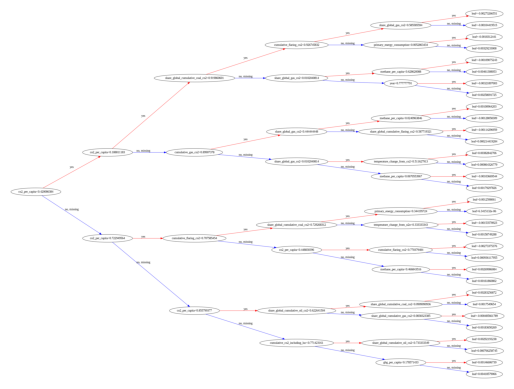

In [89]:
# XGBoost
plot_and_save_xgboost_tree(best_params, X_train_top, y_train)

In [90]:
# Function to plot Predicted vs. actual values
def plot_predicted_vs_actual(y_predictions):
    models = list(y_predictions.keys())
    num_models = len(models)
    num_plots_per_row = 4
    num_rows = int(np.ceil(num_models / num_plots_per_row))

    fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 10))
    fig.tight_layout(pad=4.0)

    for i, model_name in enumerate(models):
        row = i // num_plots_per_row
        col = i % num_plots_per_row

        ax = axes[row, col] if num_rows > 1 else axes[col]

        predictions = y_predictions[model_name]
        ax.scatter(y_predictions['Actual'], predictions, alpha=0.7)
        ax.plot([min(y_predictions['Actual']), max(y_predictions['Actual'])],
                [min(y_predictions['Actual']), max(y_predictions['Actual'])],
                linestyle='--', color='gray', linewidth=2)
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'{model_name} - Predicted vs Actual Values\nR-squared: {r2_score(y_predictions["Actual"], predictions):.3f}')

    # Hide unused subplots if there are any
    for i in range(len(models), num_rows * num_plots_per_row):
        row = i // num_plots_per_row
        col = i % num_plots_per_row
        axes[row, col].axis('off')

    # Save each image as PNG
    plt.savefig('predicted_vs_actual.png')
    plt.subplots_adjust(hspace=0.4)
    plt.show()


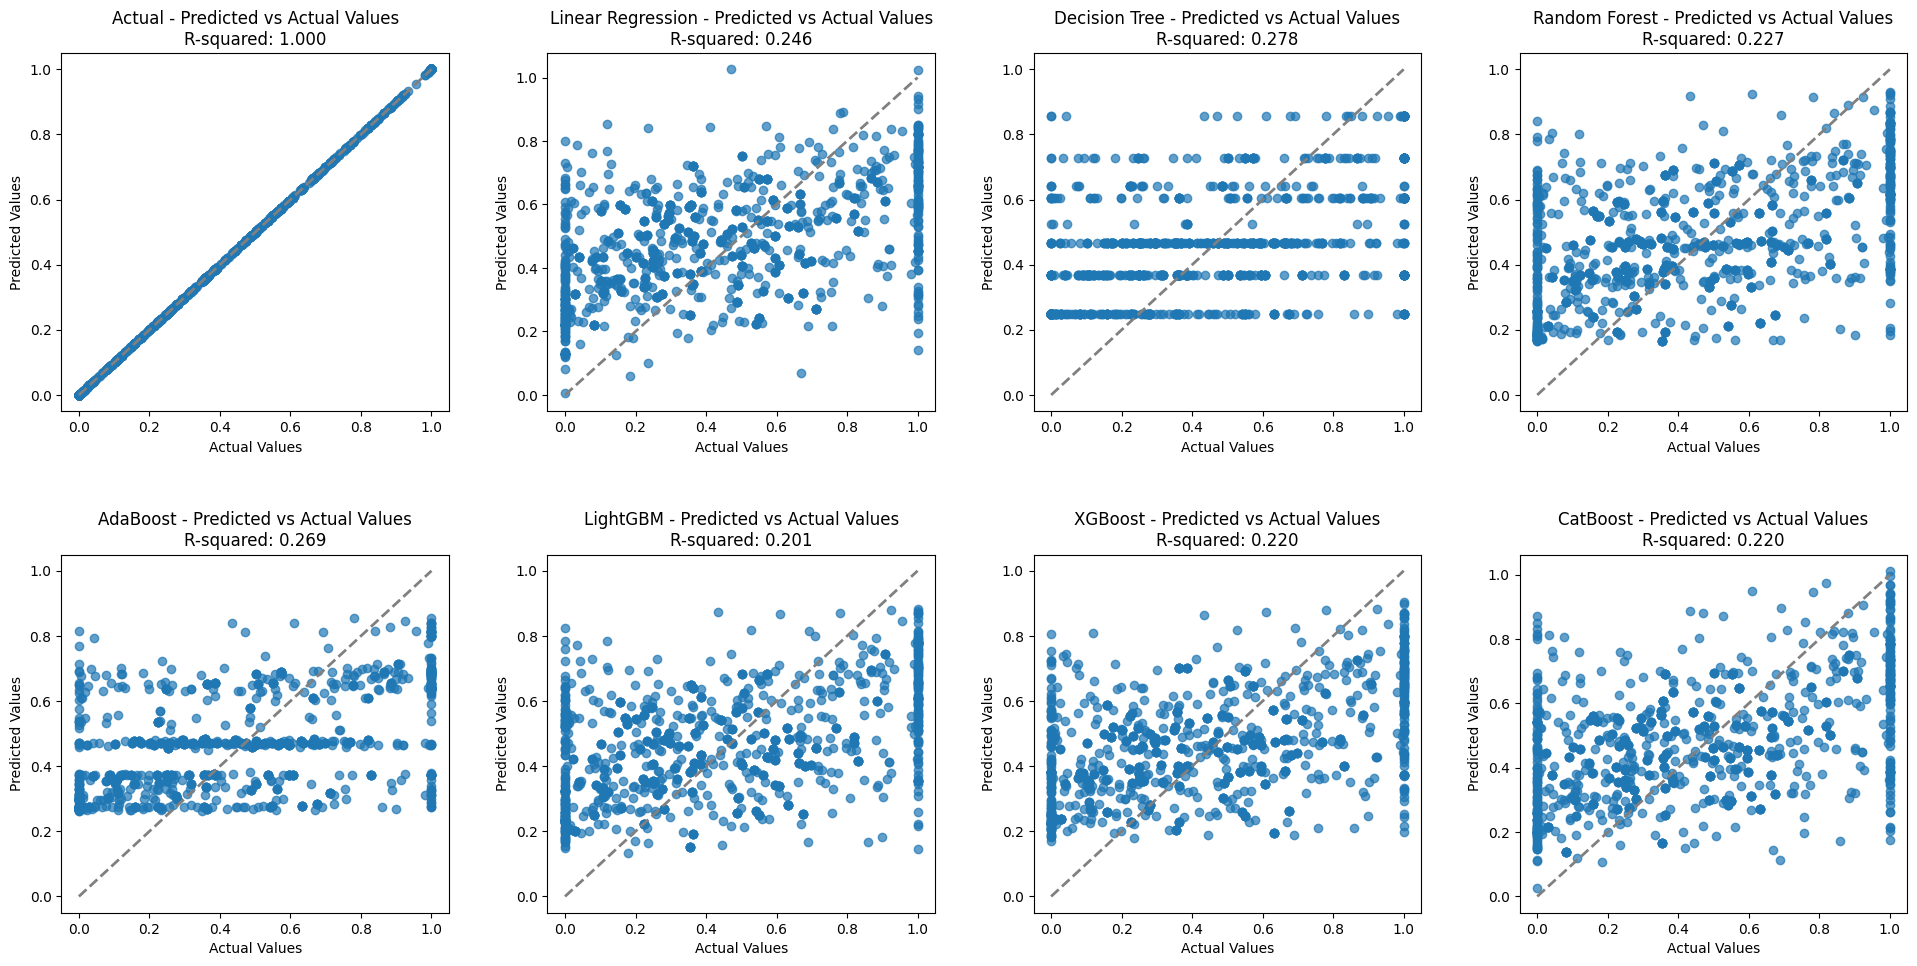

In [91]:
# Predicted vs actual
plot_predicted_vs_actual(y_predictions_df)